# Getting Started with Python SDK

## Prerequisites

This is a simple inference example using MNIST model. To run the following examples, you must install NPU driver, firmware, and runtime by following [FuriosaAI Driver, Firmware, Runtime Installation Guide](https://furiosa-ai.github.io/docs/latest/ko/software/installation.html).

After then, you need to install the following python packages:
```sh
pip install furiosa-sdk matplotlib mnist
```
Or, you can run the following command to install all dependent packages for all notebook examples at once:
```sh
pip install -r requirements.txt
```

Then, you are now ready to run the following examples.

## Checking environment
First, let's check if your NPU device is ready as following:

In [1]:
!furiosactl info

+------+--------+----------------+-------+--------+--------------+
| NPU  | Name   | Firmware       | Temp. | Power  | PCI-BDF      |
+------+--------+----------------+-------+--------+--------------+
| npu0 | warboy | 1.7.0, 0a4411e |  38°C | 2.15 W | 0000:49:00.0 |
+------+--------+----------------+-------+--------+--------------+


Depending on your device and environment, some information can be different from the output shown above. `furiosactl` prints out the summary of your NPU device.

Then, let's make sure that your SDK is ready to run immediately by running the following command. If you see any error here, please follow the instructions at
* [FuriosaAI Driver, Firmware, Runtime Installation Guide](https://furiosa-ai.github.io/docs/latest/ko/software/installation.html)
* [Setting up a Python Environment](https://furiosa-ai.github.io/docs/latest/ko/software/python-sdk.html#python)

In [2]:
!python -c "from furiosa import runtime;print(runtime.__full_version__)"

libfuriosa_hal.so --- v0.11.0, built @ 43c901f
Furiosa SDK Runtime 0.10.0-dev (rev: e80482f4) (libnux 0.9.0 062c7dd1f 2023-04-12T20:55:14Z)


## Preparing dataset

Here, we are going to show how you can do inferences through `furiosa-sdk` with NPU. For that, we need a model and sample dataset. Here, we will use MNIST model and its dataset. This example already includes the MNIST model at `./models` directory, and its dataset can be quickly available by importing `mnist` python package.

In [3]:
# Import MNIST dataset package
import mnist

# The following line will download the MNIST dataset through the network.
train_images = mnist.train_images()
train_images.shape

(60000, 28, 28)

Now, you already have the sample dataset.

## Running furiosa-sdk

To enable `furiosa-sdk` in your Python script, you need to import `furiosa.runtime` simply as following:

In [4]:
from furiosa.runtime import session

libfuriosa_hal.so --- v0.11.0, built @ 43c901f


Next, let's import other python packages for numpy array and images:

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import random

### Compiling Tflite or Onnx model

As the first step to run inferences on NPU, you have to create a `Session` object by calling `session.create()`. This step involves a model compilation and NPU initialization.

In [6]:
%%time
sess = session.create('models/MNIST_MobileNet_v2_uint8_quant_without_avgpool_softmax.tflite')

2023-04-13T23:43:14.260399Z  INFO nux::npu: Npu (npu0pe0-1) is being initialized
2023-04-13T23:43:14.265231Z  INFO nux: NuxInner create with pes: [PeId(0)]
CPU times: user 27.1 ms, sys: 13.4 ms, total: 40.4 ms
Wall time: 77.9 ms


Saving the compilation log into /home/hyunsik/.local/state/furiosa/logs/compile-20230413184314-mikh9t.log
Using furiosa-compiler 0.9.0 (rev: 062c7dd1f built at 2023-04-12T20:55:14Z)


`session.create()` can take more options. As an example, `device` allows to specify a certain NPU device. For example, you can set `device="npu0pe0-1"` to use a 2PE-fusioned NPU. You can also use 2 PEs individually if you set `device="npu0pe0"` or `device="npu0pe1"`. You can find more options in Python API Reference.

Once `session` object is created, you are able get model information, such as input and output tensors shapes and their data type as following:

In [7]:
sess.print_summary()

Inputs:
{0: TensorDesc(shape=(1, 28, 28, 1), dtype=UINT8, format=NHWC, size=784, len=784)}
Outputs:
{0: TensorDesc(shape=(1, 10), dtype=UINT8, format=??, size=10, len=10)}


In [8]:
sess.inputs() # returns List[TensorDesc]

[TensorDesc(shape=(1, 28, 28, 1), dtype=UINT8, format=NHWC, size=784, len=784)]

In [9]:
sess.outputs() # returns List[TensorDesc]

[TensorDesc(shape=(1, 10), dtype=UINT8, format=??, size=10, len=10)]

### Running Inferences

Now, let's try to run an inference from the `Session` object. For that, we need to prepare an sample image for MNIST model. `Session.run()` is the function to run an inference. It takes one or more *numpy* arrays as input tensors and returns `TensorArray` which can be also converted to *numpy* array. 

The followings transform one of MNIST training images to a numpy array.

(1, 28, 28, 1)
(1, 28, 28, 1)


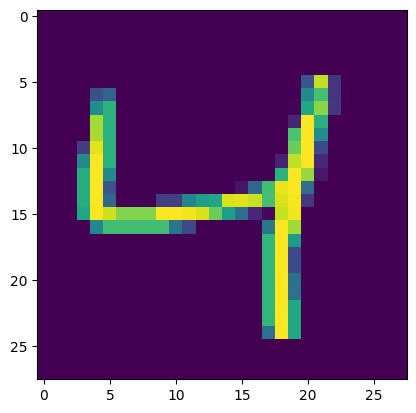

In [10]:
# Converts a single image to a numpy array `input`
input = np.array(train_images[2:3].reshape(1, 28, 28, 1), np.uint8)
print(sess.input(0).shape)
print(input.shape)

# Show the input image
test_image = input.reshape(28, 28)
plt.figure()
plt.imshow(test_image, interpolation='nearest')

The following runs 100 inferences and measure their walltimes.

In [11]:
%%timeit -n100

idx = random.randint(0, 59999)
input = np.array(train_images[idx:idx+1].reshape(1, 28, 28, 1), np.uint8)
outputs = sess.run(input)

122 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`Session.run()` returns a list of tensors, and this model has only one output tensor.

In [12]:
outputs = sess.run(input)
outputs

{0: Tensor(shape=(1, 10), dtype=UINT8)}

You can also handle the output as a list and you can access a specific tensor as following:

In [13]:
outputs[0]

Tensor(shape=(1, 10), dtype=UINT8)

To convert the output tensor to a numpy array, please run as following:

In [14]:
outputs[0].numpy()

array([[117, 151, 116, 120, 159, 117, 116, 142, 104, 133]], dtype=uint8)

As you can see, the output of MNIST model is a tensor shaped `(1, 10)`, each of elements is the probability of the corresponding number. Let's print out what number has the highest probability.

In [15]:
np.argmax(outputs[0].numpy())

4

The answer will be the same as you saw the above image.

`Session` will be holding the NPU device until `Session.close()` is called if you keep this notebook session. To run other notebook examples, please free the NPU device as following:

In [16]:
sess.close()

2023-04-13T23:43:14.603499Z  INFO nux::npu: NPU (npu0pe0-1) has been destroyed
2023-04-13T23:43:14.603643Z  INFO nux::capi: session has been destroyed
